In [40]:
# Import libraries
import os
import numpy as np
import MDAnalysis as mda
import nmrformd as nmrmd

recalculate=True

# For figure plotting
import sys
from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fontsize = 30
font = {'family': 'sans', 'color':  'black', 'weight': 'normal', 'size': fontsize}
myblue = [0/ 255, 150/255, 177/ 255]
lightgray = [0.1, 0.1, 0.1]
darkgray = [0.9, 0.9, 0.9]
myred= [255/ 255, 77/255, 77/ 255]
sys.path.append('../../shared/')
from tools import figure_improvement, save_figure

# Path to data
numbers_mol = np.int32(np.logspace(np.log10(25), np.log10(4000), 12))
datapath = "../../raw-data/bulk-water/"

scalar_properties = []
intra_gij = []
intra_R1 = []
intra_R2 = []
intra_J = []
inter_gij = []
inter_R1 = []
inter_R2 = []
inter_J = []

for number_mol in numbers_mol:
    if recalculate:
        u = None
        data = datapath+"N"+str(number_mol)+"/"
        if os.path.exists(data+"topology.data"):
            u = mda.Universe(data+"topology.data", data+"prod.xtc")
            group_i = u.select_atoms("type 2")
        elif os.path.exists(data+"run.tpr"):
            u = mda.Universe(data+"run.tpr", data+"run.xtc")
            group_i = u.select_atoms("type HW")
        if u is not None:
            timestep = np.int32(u.trajectory.dt)
            total_time = np.int32(u.trajectory.totaltime)
            n_molecules = u.atoms.n_residues
            assert n_molecules == number_mol
            v_box = np.round(np.prod(u.dimensions[:3]) / 1000,1)
            print("The number of water molecules is", n_molecules, "and the density is", np.round(n_molecules/v_box,2), "molecule per nm3")
            print("----------------------------------------------------------------------------")
            # cut-off for frequency and time
            f_1 = 1
            t_1 = 2
            if u.trajectory.n_frames == 10001:
                f_1 = 2600
                t_1 = 9000
            # Run NMRforMD - intra
            nmr_intra = nmrmd.NMR(u, group_i, isotropic=True, type_analysis="intra_molecular", number_i=300)
            t, gij_intra = nmr_intra.t[:-t_1], nmr_intra.gij[0][:-t_1]
            f, R1_intra = nmr_intra.f[:-f_1], nmr_intra.R1[:-f_1]
            f, R2_intra = nmr_intra.f[:-f_1], nmr_intra.R2[:-f_1]
            f, J_intra = nmr_intra.f[:-f_1], nmr_intra.J[0][:-f_1]
            intra_gij.append(gij_intra)
            intra_R1.append(R1_intra)
            intra_R2.append(R2_intra)
            intra_J.append(J_intra)
            np.savetxt("../../treated-data/best-practice/bulk-water/gij_intra_finite_size.dat", np.vstack([t, intra_gij]).T)
            np.savetxt("../../treated-data/best-practice/bulk-water/R1_intra_finite_size.dat", np.vstack([f, intra_R1]).T)
            np.savetxt("../../treated-data/best-practice/bulk-water/R2_intra_finite_size.dat", np.vstack([f, intra_R2]).T)
            np.savetxt("../../treated-data/best-practice/bulk-water/J_intra_finite_size.dat", np.vstack([f, intra_J]).T)
            # Run NMRforMD - inter
            nmr_inter = nmrmd.NMR(u, group_i, isotropic=True, type_analysis="inter_molecular", number_i=100)
            t, gij_inter = nmr_inter.t[:-t_1], nmr_inter.gij[0][:-t_1]
            f, R1_inter = nmr_inter.f[:-f_1], nmr_inter.R1[:-f_1]
            f, R2_inter = nmr_intra.f[:-f_1], nmr_inter.R2[:-f_1]
            f, J_inter = nmr_inter.f[:-f_1], nmr_inter.J[0][:-f_1]
            inter_gij.append(gij_inter)
            inter_R1.append(R1_inter)
            inter_R2.append(R2_inter)
            inter_J.append(J_inter)
            np.savetxt("../../treated-data/best-practice/bulk-water/gij_inter_finite_size.dat", np.vstack([t, inter_gij]).T)
            np.savetxt("../../treated-data/best-practice/bulk-water/R1_inter_finite_size.dat", np.vstack([f, inter_R1]).T)
            np.savetxt("../../treated-data/best-practice/bulk-water/R2_inter_finite_size.dat", np.vstack([f, inter_R2]).T)
            np.savetxt("../../treated-data/best-practice/bulk-water/J_inter_finite_size.dat", np.vstack([f, inter_J]).T)
            # Save volume
            scalar_properties.append([number_mol, v_box])
            np.savetxt("../../treated-data/best-practice/bulk-water/scalar_finite_size.dat", scalar_properties)
    else:
        data = np.loadtxt("../../treated-data/best-practice/bulk-water/gij_intra_finite_size.dat").T
        t, intra_gij = data[0], data[1:]
        data = np.loadtxt("../../treated-data/best-practice/bulk-water/gij_inter_finite_size.dat").T
        t, inter_gij = data[0], data[1:]
        data = np.loadtxt("../../treated-data/best-practice/bulk-water/R1_inter_finite_size.dat").T
        f, inter_R1 = data[0], data[1:]
        data = np.loadtxt("../../treated-data/best-practice/bulk-water/R1_intra_finite_size.dat").T
        f, intra_R1 = data[0], data[1:]
        data = np.loadtxt("../../treated-data/best-practice/bulk-water/R2_inter_finite_size.dat").T
        f, inter_R2 = data[0], data[1:]
        data = np.loadtxt("../../treated-data/best-practice/bulk-water/R2_intra_finite_size.dat").T
        f, intra_R2 = data[0], data[1:]
        data = np.loadtxt("../../treated-data/best-practice/bulk-water/J_inter_finite_size.dat").T
        f, inter_J = data[0], data[1:]
        data = np.loadtxt("../../treated-data/best-practice/bulk-water/J_intra_finite_size.dat").T
        f, intra_J = data[0], data[1:]
        scalar_properties = np.loadtxt("../../treated-data/best-practice/bulk-water/scalar_finite_size.dat")

The number of water molecules is 25 and the density is 31.25 molecule per nm3
----------------------------------------------------------------------------
Note : number_i is larger than the number of atoms in group target i
-> The number_i value will be ignored-> All the atoms of the group i have been selected
Note : number_i is larger than the number of atoms in group target i
-> The number_i value will be ignored-> All the atoms of the group i have been selected
The number of water molecules is 39 and the density is 32.5 molecule per nm3
----------------------------------------------------------------------------
Note : number_i is larger than the number of atoms in group target i
-> The number_i value will be ignored-> All the atoms of the group i have been selected
Note : number_i is larger than the number of atoms in group target i
-> The number_i value will be ignored-> All the atoms of the group i have been selected
The number of water molecules is 62 and the density is 32.63 mo

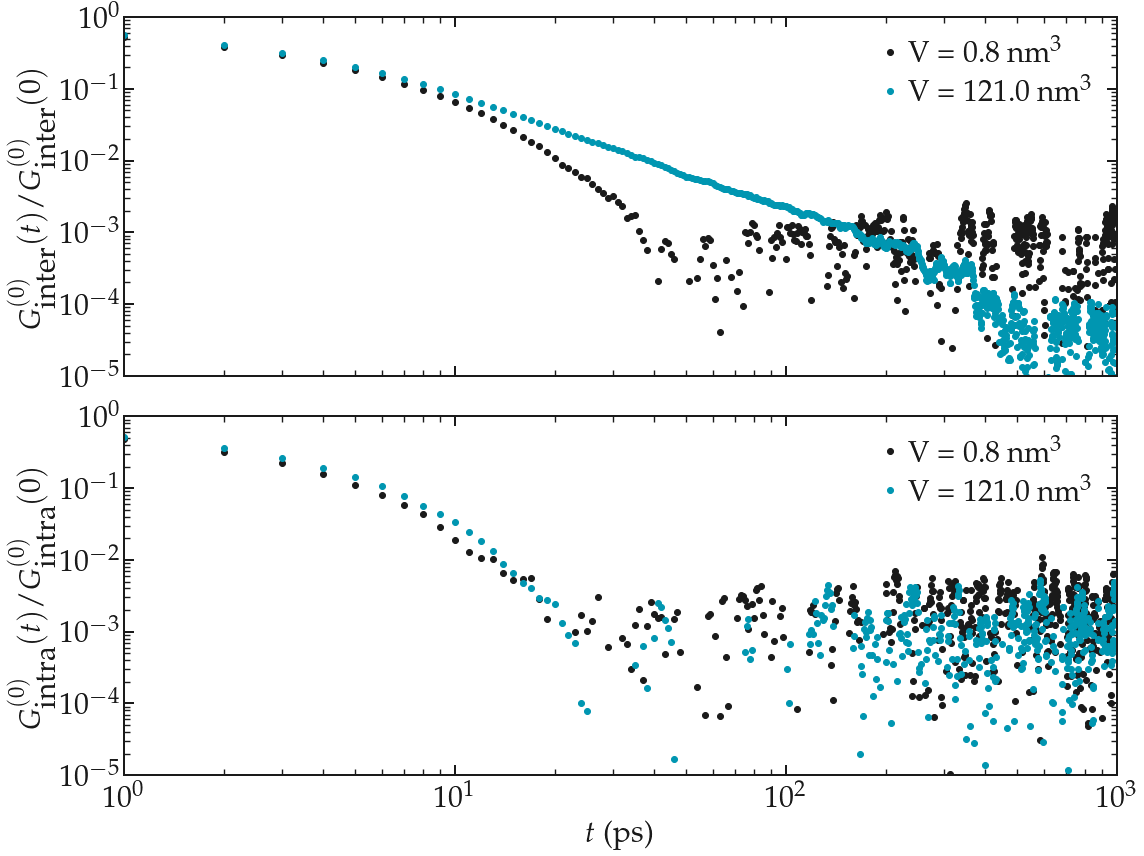

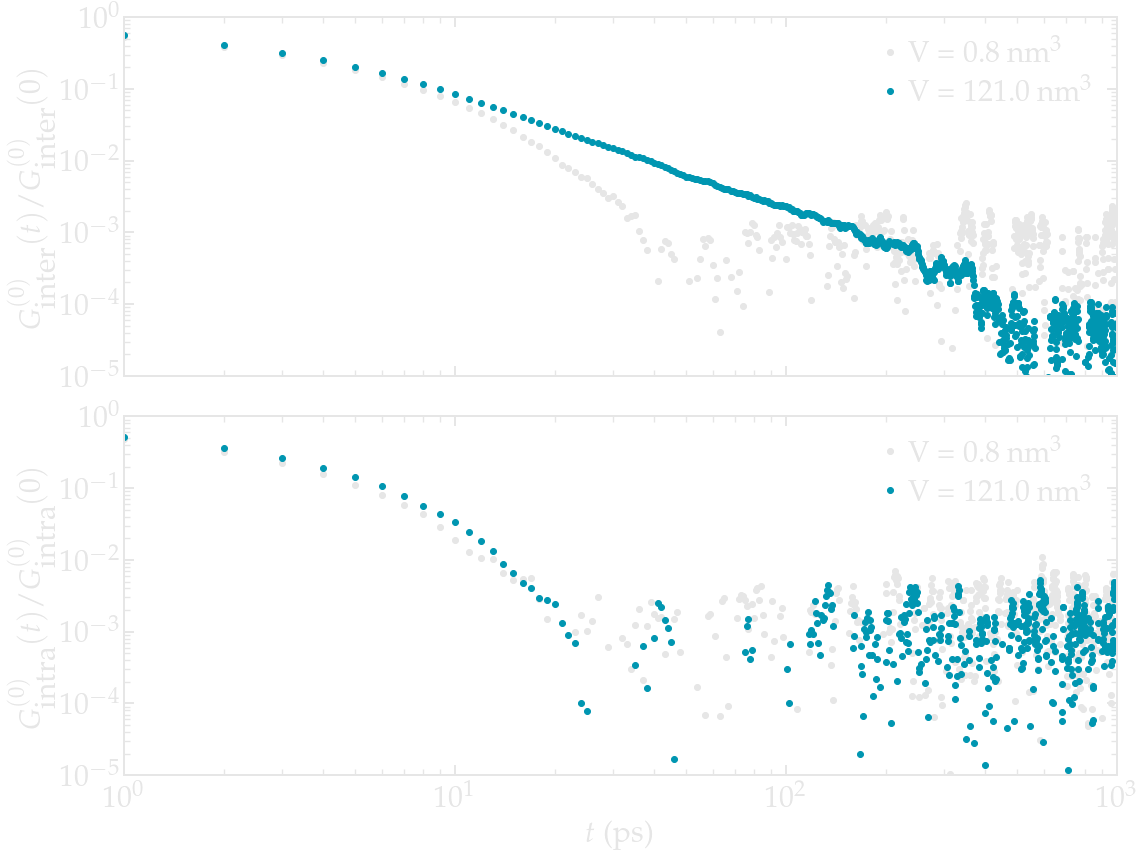

In [28]:
for mode, mygray in zip(['light', 'dark'], [lightgray, darkgray]):

    R = np.linspace(mygray[0], myblue[0], len(numbers_mol)//6)
    G = np.linspace(mygray[1], myblue[1], len(numbers_mol)//6)
    B = np.linspace(mygray[2], myblue[2], len(numbers_mol)//6)
    grad = np.vstack([R, G, B]).T

    fig = plt.figure(figsize=(16, 12))
    ax1 = fig.add_subplot(211)
    cpt = 0
    for inter, n_mol in zip(inter_gij[::11], scalar_properties[::11]):
        ax1.loglog(t, inter/inter[0], 'o', color=grad[cpt], label=r"V = "+str(n_mol[1])+" nm$^3$")
        cpt += 1
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=None, ylabel=r'$G^{(0)}_\textrm{inter} (t) / G^{(0)}_\textrm{inter} (0)$',
                       xlim=(1, 1000), ylim=(0.00001, 1))
    ax1 = fig.add_subplot(212)
    cpt = 0
    for intra, n_mol in zip(intra_gij[::11], scalar_properties[::11]):
        ax1.loglog(t, intra/intra[0], 'o', color=grad[cpt], label=r"V = "+str(n_mol[1])+" nm$^3$")
        cpt += 1
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$t$ (ps)", ylabel=r'$G^{(0)}_\textrm{intra} (t) / G^{(0)}_\textrm{intra} (0)$',
                       xlim=(1, 1000), ylim=(0.00001, 1))
    save_figure(plt, fig, mode, name='best-practices/size-effect-gij')

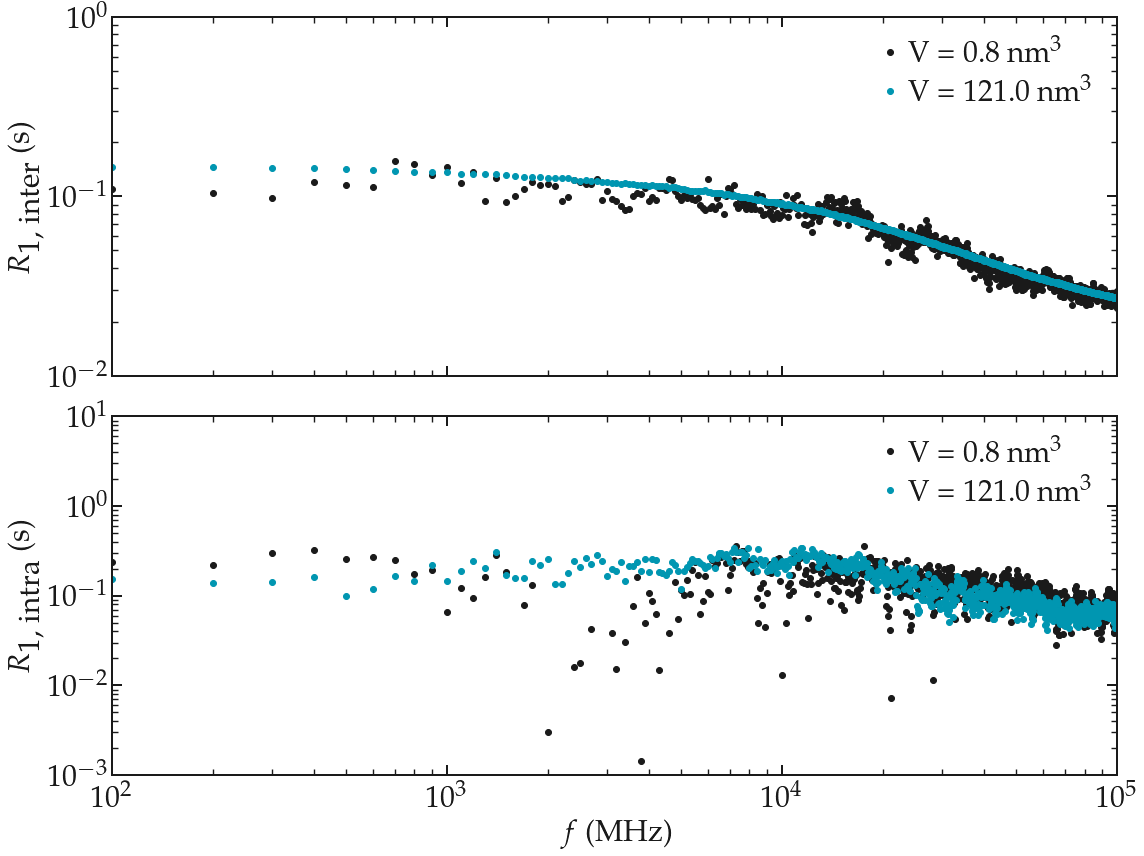

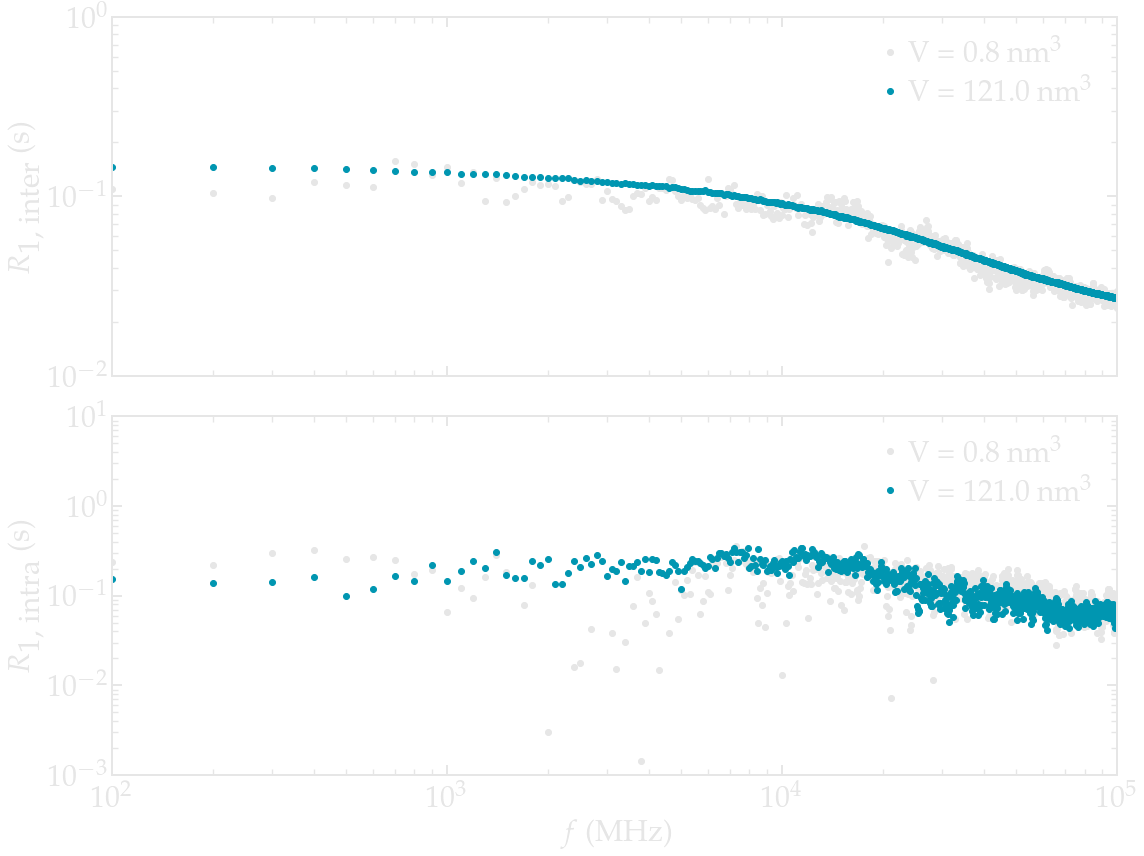

In [29]:
for mode, mygray in zip(['light', 'dark'], [lightgray, darkgray]):

    R = np.linspace(mygray[0], myblue[0], len(numbers_mol)//6)
    G = np.linspace(mygray[1], myblue[1], len(numbers_mol)//6)
    B = np.linspace(mygray[2], myblue[2], len(numbers_mol)//6)
    grad = np.vstack([R, G, B]).T

    fig = plt.figure(figsize=(16, 12))
    ax1 = fig.add_subplot(211)
    cpt = 0
    for inter, n_mol in zip(inter_R1[::11], scalar_properties[::11]):
        ax1.loglog(f, inter, 'o', color=grad[cpt], label=r"V = "+str(n_mol[1])+" nm$^3$")
        cpt += 1
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=None, ylabel=r'$R_\textrm{1, inter}$ (s)',
                       xlim=(100, 100000), ylim=(0.01, 1))
    ax1 = fig.add_subplot(212)
    cpt = 0
    for intra, n_mol in zip(intra_R1[::11], scalar_properties[::11]):
        ax1.loglog(f, intra, 'o', color=grad[cpt], label=r"V = "+str(n_mol[1])+" nm$^3$")
        cpt += 1
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$f$ (MHz)", ylabel=r'$R_\textrm{1, intra}$ (s)',
                       xlim=(100, 100000), ylim=(0.001, 10))
    save_figure(plt, fig, mode, name='best-practices/size-effect-R1')

In [26]:
sys.path.append("../../../nmrformd/")
from utilities import calculate_tau

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


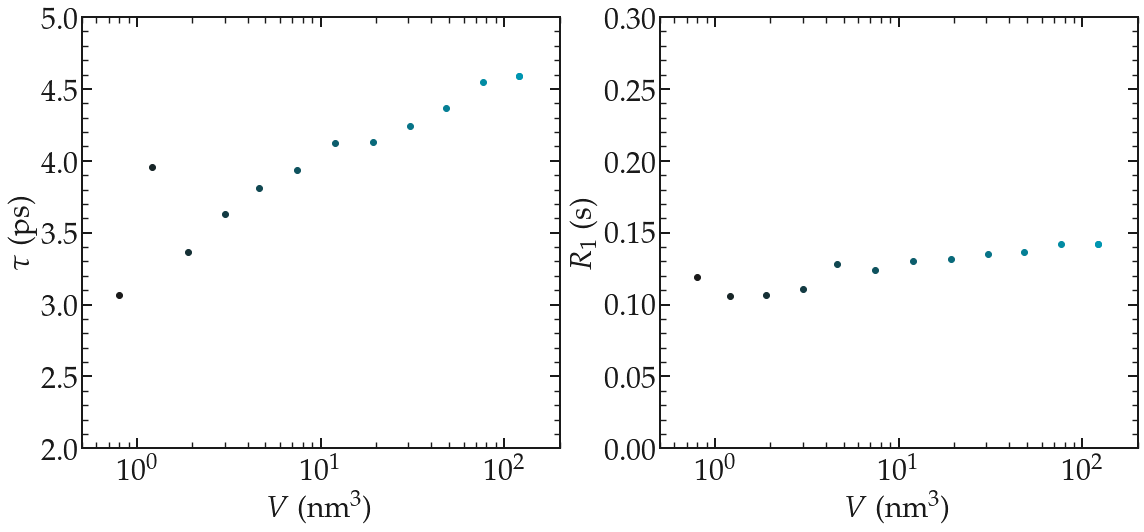

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


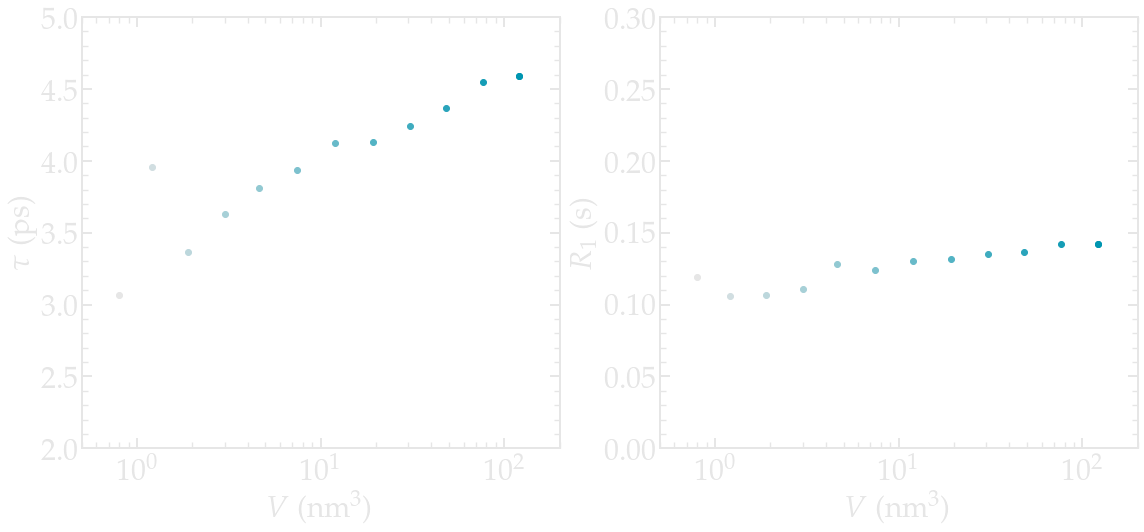

In [39]:
for mode, mygray in zip(['light', 'dark'], [lightgray, darkgray]):

    R = np.linspace(mygray[0], myblue[0], len(numbers_mol))
    G = np.linspace(mygray[1], myblue[1], len(numbers_mol))
    B = np.linspace(mygray[2], myblue[2], len(numbers_mol))
    grad1 = np.vstack([R, G, B]).T
    R = np.linspace(mygray[0], myred[0], len(numbers_mol))
    G = np.linspace(mygray[1], myred[1], len(numbers_mol))
    B = np.linspace(mygray[2], myred[2], len(numbers_mol))
    grad2 = np.vstack([R, G, B]).T

    fig = plt.figure(figsize=(16, 7.5))
    ax1 = fig.add_subplot(121)
    cpt = 0
    for J, gij, n_mol in zip(inter_J, inter_gij, scalar_properties):
        tau_inter = calculate_tau(J, gij, 0, oneDarray=True)
        ax1.semilogx(n_mol[1], tau_inter, 'o', color=grad1[cpt])
        cpt += 1
    ax1.semilogx(n_mol[1], tau_inter, 'o', color=grad1[cpt-1]) #, label=r"inter")
    #cpt = 0
    #for J, gij, n_mol in zip(intra_J, intra_gij, scalar_properties):
    #    tau_intra = calculate_tau(J, gij, 0, oneDarray=True)
    #    ax1.loglog(n_mol[1], tau_intra, 's', color=grad2[cpt])
    #    cpt += 1
    #ax1.loglog(n_mol[1], tau_intra, 's', color=grad2[cpt-1], label=r"intra")
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r'$V$ (nm$^3$)', ylabel=r'$\tau$ (ps)',
                       xlim=(0.5, 200), ylim=(2, 5))

    ax1 = fig.add_subplot(122)
    cpt = 0
    for iR1, n_mol in zip(inter_R1, scalar_properties):
        tau_inter = np.mean(iR1[:10])
        ax1.semilogx(n_mol[1], tau_inter, 'o', color=grad1[cpt])
        cpt += 1
    ax1.semilogx(n_mol[1], tau_inter, 'o', color=grad1[cpt-1]) #, label=r"inter")
    #cpt = 0
    #for iR1, n_mol in zip(intra_R1, scalar_properties):
    #    tau_intra = np.mean(iR1[:10])
    #    ax1.loglog(n_mol[1], tau_intra, 's', color=grad2[cpt])
    #    cpt += 1
    #ax1.loglog(n_mol[1], tau_intra, 's', color=grad2[cpt-1], label=r"intra")
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r'$V$ (nm$^3$)', ylabel=r'$R_1$ (s)',
                       xlim=(0.5, 200), ylim=(0.0, 0.3))
    save_figure(plt, fig, mode, name='best-practices/size-effect-tau-R1')